# AutoEncoder 구축하기
- 간단한 오토 인코더 구축에 대해서 다룹니다.
- 간단하기 때문에 참고만 하는 것이 좋을 것 같아요.

### 패키지 로딩

In [2]:
### Data Handling
import pandas as pd
import numpy as np

### fix seed
import random
import os
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42)

### keras & tensorflow
import keras
from keras import layers
import tensorflow as tf

### scoring
import sklearn.metrics as metrics

### 데이터 로딩

In [108]:
### 데이터 로딩
X = pd.read_csv("C:\LG_Aimers\data\Train-Test-Split\X_train.csv")
y = pd.read_csv("C:/LG_Aimers/data/Train-Test-Split/y_train.csv")

### numpy 변환
X = X.drop(columns = ["Unnamed: 0"])
X=np.array(X)
y = y.drop(columns = ["Unnamed: 0"])
y=np.array(y)
print("X : ", X.shape)
print("y : ", y.shape)

#### 모델 구축

In [ ]:
### 모델 구축
input = layers.Input(shape=(X.shape[1],))
encoded = layers.Dense(512, activation='relu')(input)
encoded = layers.Flatten(256)(encoded)
encoded = layers.Dense(128, activation='relu')(encoded)
encoded = layers.Flatten(64)(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded = layers.Flatten(16)(encoded)
encoded = layers.Dense(8, activation='relu')(encoded)
encoded = layers.Flatten(4)(encoded)
encoded = layers.Dense(2, activation='relu')(encoded)
decoded = layers.Dense(y.shape[1], activation='relu')(encoded)

### 모델 형성
autoencoder = keras.Model(inputs=input, outputs=decoded)
autoencoder.summary()

### 최적화 방식 결정 및 학습

In [ ]:
# 파라미터 설정
epochs = 300
batch_size = 128
learning_rate = 0.001
validation = 0.2

# compile
autoencoder.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate))

# 모델학습
history = autoencoder.fit(
    X,
    y,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

# 모델 저장
autoencoder.save('autoencoder.h5')

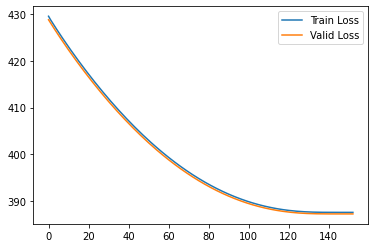

In [ ]:
# 학습 결과 표시
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Valid Loss")
plt.legend()
plt.show()

### 예측 데이터 전처리

In [ ]:
X_valid = pd.read_csv("C:\LG_Aimers\data\Train-Test-Split\X_valid.csv")
y_valid = pd.read_csv("C:/LG_Aimers/data/Train-Test-Split/y_valid.csv")
X_valid = X_valid.drop(columns = ["Unnamed: 0"])
X_valid=np.array(X_valid)
X_valid = X_valid.reshape(X_valid.shape[0],X_valid.shape[1])
y_valid = y_valid.drop(columns = ["Unnamed: 0"])
y_valid=np.array(y_valid)
y_valid = y_valid.reshape(y_valid.shape[0],y_valid.shape[1])

### 예측 및 평가

In [ ]:
### 예측
y_predict = autoencoder.predict(X_valid)
print("predict shape : ", y_predict.shape)

### 저장
y_predict = pd.DataFrame(y_predict.reshape(7922,14))
y_valid = pd.read_csv("C:/LG_Aimers/data/Train-Test-Split/y_valid.csv")
y_valid.drop(columns = ["Unnamed: 0"],inplace=True)

### 평가를 위한 준비
y_predict.columns = y_valid.columns
y_valid = np.array(y_valid)
y_predict = np.array(y_predict)

### score 함수 정의
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = metrics.mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score

### 점수 도출
print(lg_nrmse(y_valid, y_predict))